<a href="https://colab.research.google.com/github/affanzafar99/Plant-Disease-Classification-ResNet/blob/main/Custom_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the number of files in each folder

In [ ]:
import os

from os.path import join, getsize
for root, dirs, files in os.walk('/content/drive/MyDrive/Plant_Pathology/train'):
    print(root, "consumes", end=" ")
    print(sum(getsize(join(root, name)) for name in files), end=" ")
    print("bytes in", len(files), "non-directory files")
    if 'CVS' in dirs:
        dirs.remove('CVS')  # don't visit CVS directories

/content/drive/MyDrive/Plant_Pathology/train consumes 0 bytes in 0 non-directory files
/content/drive/MyDrive/Plant_Pathology/train/rust consumes 137548958 bytes in 622 non-directory files
/content/drive/MyDrive/Plant_Pathology/train/scab consumes 120275453 bytes in 592 non-directory files
/content/drive/MyDrive/Plant_Pathology/train/multiple_diseases consumes 20367110 bytes in 91 non-directory files
/content/drive/MyDrive/Plant_Pathology/train/healthy consumes 123665033 bytes in 516 non-directory files


In [ ]:
for root,dirs,files in os.walk('/content/drive/MyDrive/Plant_Pathology/test'):
    print(root, "consumes", end=" ")
    print(sum(getsize(join(root, name)) for name in files), end=" ")
    print("bytes in", len(files), "non-directory files")
    if 'CVS' in dirs:
        dirs.remove('CVS')  # don't visit CVS directories


lis=os.listdir('/content/drive/MyDrive/Plant_Pathology/train/healthy')
print(len(lis))


/content/drive/MyDrive/Plant_Pathology/test consumes 421831303 bytes in 1821 non-directory files
516


##Importing libraries and Preprocessing data

In [ ]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import natsort
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.datasets as datasets

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.5],[0.5])
        ])

In [ ]:
#dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Plant_Pathology/train',
#                                           transform=transforms.Compose([transforms.ToTensor()]))

dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Plant_Pathology/train',
                                           transform=train_transforms)




In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 1821
    Root location: /content/drive/MyDrive/Plant_Pathology/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [ ]:
print(dataset[2][0].shape)

torch.Size([3, 128, 128])


In [ ]:
#trainloader = DataLoader(dataset, batch_size= 20,
#                                         shuffle=True, num_workers=3)

In [ ]:
dataset_size = len(dataset)
print(dataset_size)

1821


In [ ]:
class_names=dataset.classes

print(class_names)

['healthy', 'multiple_diseases', 'rust', 'scab']


In [ ]:
#code to split dataset into training and validation set

validation_split=0.1
indices = list(range(dataset_size))
split = int(np.floor(validation_split*dataset_size))
np.random.seed(1)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#print(val_indices)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

print(len(train_sampler))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=20, 
                                           sampler=train_sampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=20,
                                                sampler=valid_sampler, num_workers=0)

1639


In [ ]:
#mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
#train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=20, num_workers=0)

#Model Definition

In [ ]:
from torch.nn import Conv2d, functional as F, Linear, MaxPool2d

#import torch

In [ ]:
class Network(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv11 = Conv2d(3,64,kernel_size=3, stride=1, padding= 1)
    self.conv12 = Conv2d(64,64,kernel_size=3,stride=1,padding=1)
    self.batch1 = nn.BatchNorm2d(64)
    self.pool1 = MaxPool2d(kernel_size=2)

    self.conv21 = Conv2d(64,128,kernel_size=3, stride=1, padding=1)
    self.conv22 = Conv2d(128,128,kernel_size=3,stride=1,padding=1)
    self.batch2 = nn.BatchNorm2d(128)
    self.pool2 = MaxPool2d(kernel_size=2)

    self.conv31 = Conv2d(128,256,kernel_size=3, stride=1, padding=1)
    self.conv32 = Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.batch3 = nn.BatchNorm2d(256)
    self.pool3 = MaxPool2d(kernel_size=2)

    self.conv41 = Conv2d(256,512,kernel_size=3, stride=1, padding=1)
    self.conv42 = Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.batch4 = nn.BatchNorm2d(512)
    self.pool4 = MaxPool2d(kernel_size=2)

    self.fc1 = Linear(512*8*8,64)
    self.fc2 = Linear(64,4)

  def forward(self, X):
    #print(X.shape)
    X=F.relu(self.conv11(X))
    X=F.relu(self.conv12(X))
    X=self.batch1(X)
    X = self.pool1(X)
    #print(X.shape)
    X=F.relu(self.conv21(X))
    X=F.relu(self.conv22(X))
    #X=nn.BatchNorm2d(X)
    X=self.batch2(X)
    X = self.pool2(X)
    #print(X.shape)
    X=F.relu(self.conv31(X))
    X=F.relu(self.conv32(X))
    #X=nn.batch_norm(X)
    X=self.batch3(X)
    X = self.pool3(X)
    #print(X.shape)
    X=F.relu(self.conv41(X))
    X=F.relu(self.conv42(X))
    #X=nn.batch_norm(X)
    X=self.batch4(X)
    X = self.pool4(X)
    #print(X.shape)
    X = X.view(-1,X.shape[1]*X.shape[2]*X.shape[3])
    X = F.relu(self.fc1(X))
    X = self.fc2(X)
    return X

In [ ]:
import PIL

In [ ]:
len(train_loader)

82

In [ ]:
images, labels = next(iter(train_loader))
print(len(images))

20


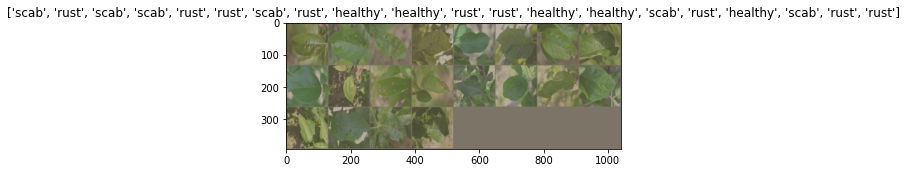

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

#RESNET

In [ ]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
resnet

In [ ]:
resnet.fc=nn.Linear(512,4)

In [ ]:
resnet = resnet.cuda()

In [ ]:
resParams = resnet.parameters()
list(resParams)[61].requires_grad

True

In [ ]:
#reset freeze layers
for param in resnet.parameters():
  param.requires_grad = True

In [ ]:
print(resnet.parameters())

In [ ]:
count = 1
for param in resnet.parameters():
  if (count < 55):
    param.requires_grad = False
  count += 1
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True


#PROGRESS

In [ ]:
"""model = nn.Sequential(Conv2d(3,3,kernel_size=3,stride=1,padding=1),
                      MaxPool2d(kernel_size=3,stride=1,padding=0),
                      Linear(124*124,64),
                      Linear(64,4))
"""                      

In [ ]:
# model.parameters()

<generator object Module.parameters at 0x7f5503d94cd0>

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
model = Network()
model.parameters()

<generator object Module.parameters at 0x7fa7af39edd0>

In [ ]:
model = model.cuda()

In [ ]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
            Conv2d-2         [-1, 64, 128, 128]          36,928
       BatchNorm2d-3         [-1, 64, 128, 128]             128
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
            Conv2d-6          [-1, 128, 64, 64]         147,584
       BatchNorm2d-7          [-1, 128, 64, 64]             256
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         295,168
           Conv2d-10          [-1, 256, 32, 32]         590,080
      BatchNorm2d-11          [-1, 256, 32, 32]             512
        MaxPool2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
           Conv2d-14          [-1, 512,

In [ ]:
n_epochs = 20

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
#optimizer = optim.SGD(resnet.parameters(), lr = 0.01, momentum = 0.09)
#optimizer = optim.SGD(model.parameters(), lr = 0.00001)

In [ ]:
train_loss = []
train_acc = []
model.train()
for epoch in range(n_epochs):
  loss = []
  correct = 0
  total = 0
  print("Epoch:", epoch)
  
  for batch_idx, (data, target) in enumerate(train_loader):
    
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    #outputs = resnet(data)
    outputs = model.forward(X=data)
    loss_ = criterion(outputs, target)
    loss_.backward()
    optimizer.step()
    
    # print(outputs.data)

    loss.append(loss_.item())
    # _, pred = F.softmax(outputs.data, dim = 1)
    _, pred = torch.max(outputs, dim = 1)
    # print(pred)
    correct += torch.sum(pred == target).item()
    
    total += target.size(0)
    # print(batch_idx, "| Loss:", loss.item())
  epochAcc = correct / total * 100
  epochLoss = sum(loss) / len(loss)
  print("Accuracy:", epochAcc, "| Loss:", epochLoss)
  train_acc.append(epochAcc)
  train_loss.append(epochLoss)

print("\n\n--------------------------------------------------\n\n")
for epoch in range(1, n_epochs):
  print("Epoch:", epoch)
  print("Accuracy:", train_acc[epoch] - train_acc[epoch - 1], "| Loss:", train_loss[epoch] - train_loss[epoch - 1])

Epoch: 0
Accuracy: 37.21781574130568 | Loss: 2.0220073781362395
Epoch: 1
Accuracy: 38.13300793166565 | Loss: 1.2411953559735927
Epoch: 2
Accuracy: 42.70896888346552 | Loss: 1.205066376343006
Epoch: 3
Accuracy: 43.01403294691885 | Loss: 1.2070608524287618
Epoch: 4
Accuracy: 43.07504575960952 | Loss: 1.185994870052105
Epoch: 5
Accuracy: 46.552776082977424 | Loss: 1.1471104592811772
Epoch: 6
Accuracy: 51.3117754728493 | Loss: 1.103417347844054
Epoch: 7
Accuracy: 51.86089078706529 | Loss: 1.0997597669682853
Epoch: 8
Accuracy: 58.75533862111043 | Loss: 0.9985664276088156
Epoch: 9
Accuracy: 64.79560707748627 | Loss: 0.8857299910812844
Epoch: 10
Accuracy: 73.33740085417938 | Loss: 0.6777262258820418
Epoch: 11
Accuracy: 75.411836485662 | Loss: 0.6138774291044329
Epoch: 12
Accuracy: 76.93715680292861 | Loss: 0.5806471332907677
Epoch: 13
Accuracy: 79.43868212324588 | Loss: 0.5221594953682365
Epoch: 14
Accuracy: 86.82123245881635 | Loss: 0.40854741105946096
Epoch: 15
Accuracy: 89.0176937156803 | 

In [ ]:

os.kill(os.getpid(), 9)

In [ ]:
def save_model(state, filename="/content/drive/MyDrive/models/affanabbu.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)



checkpoint = {'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),'epochs':20}
save_model(checkpoint)

=> Saving checkpoint


In [ ]:
def make_predictions():
  ground_truth

In [ ]:
valid_sampler.classes

AttributeError: ignored

In [ ]:
def predict(image, model):
  xb = image.unsqueeze(0)
  xb = xb.to(device)
  yb = model(xb)
  _, preds = torch.max(yb, dim =1)
  return class_names[preds[0].item()]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


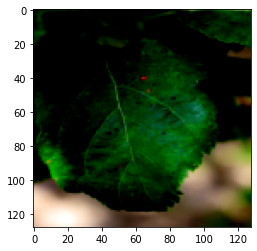

In [ ]:
img, label = dataset[val_indices[6]]
plt.imshow(img.permute(2,1,0))
print(label)

In [ ]:
class_names

['healthy', 'multiple_diseases', 'rust', 'scab']

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(lab, pr)

0.7307692307692307

In [ ]:
lab = []
pr = []
for i in val_indices:
  img, label = dataset[i]
  lab.append(class_names[label])
  pr.append(predict(img,model))
  print('Label: {}  Predicted: {}'.format(class_names[label], predict(img,model)))
  

Label: scab  Predicted: scab
Label: rust  Predicted: rust
Label: healthy  Predicted: healthy
Label: healthy  Predicted: healthy
Label: scab  Predicted: scab
Label: scab  Predicted: scab
Label: rust  Predicted: rust
Label: scab  Predicted: scab
Label: scab  Predicted: scab
Label: scab  Predicted: scab
Label: rust  Predicted: rust
Label: scab  Predicted: scab
Label: scab  Predicted: rust
Label: scab  Predicted: rust
Label: rust  Predicted: rust
Label: multiple_diseases  Predicted: scab
Label: healthy  Predicted: healthy
Label: multiple_diseases  Predicted: scab
Label: healthy  Predicted: healthy
Label: healthy  Predicted: healthy
Label: scab  Predicted: scab
Label: scab  Predicted: scab
Label: rust  Predicted: rust
Label: rust  Predicted: healthy
Label: rust  Predicted: rust
Label: healthy  Predicted: healthy
Label: rust  Predicted: rust
Label: scab  Predicted: scab
Label: healthy  Predicted: rust
Label: rust  Predicted: rust
Label: scab  Predicted: scab
Label: healthy  Predicted: health

In [ ]:
def load_model(filename="/content/drive/MyDrive/models/resnet18pre.pth.tar"):
    print("=> Loading checkpoint")
    return torch.load(filename)

resnet.load_state_dict(load_model()['state_dict'])
print(resnet)

=> Loading checkpoint


RuntimeError: ignored

In [ ]:
for p in resnet.parameters():
  print(p)

In [ ]:
from PIL import Image
import cv2

In [ ]:
class CustomDatasetClass(Dataset):
  def __init__(self,dir,transform):
    self.dir=dir
    self.transforms=transform
    images=os.listdir(dir)
    self.total = natsort.natsorted(images)

  def __len__(self):
    return len(self.total)

  def __getitem__(self, idx):
    img_loc = os.path.join(self.dir, self.total[idx])
    image = Image.open(img_loc).convert("RGB")
    # image = cv2.imread(img_loc, cv2.IMREAD_COLOR)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor_image = self.transforms(image)
    return tensor_image

In [ ]:
testDataset = CustomDatasetClass("/content/drive/MyDrive/plant pathology dataset/plant data/images/test", transform=transforms)
testLoader = DataLoader(testDataset, batch_size=1, shuffle=False, num_workers=2, drop_last=False)